# Towards Turnkey Brain-Computer Interfaces

## Dependencies

In [2]:
import os
import time
import json
import mne
import numpy as np
import pandas as pd
import seaborn as sns

import erp # see erp.py

%matplotlib inline

## Data exploration

### Open data

In [3]:
df = pd.read_hdf('../data/input/EEG.h5', 'df')

### Explore the structure

In [4]:
print(df.shape) # Number of lines and columns
print(df.columns) # Column names
print(type(df.index)) # Type of index
print(df.index.names) # Index names
print(df.index.levels[0]) # Values for the "condition" index
print(df.index.levels[1]) # Values for the "participant" index
df.head() # Display the first lines

(3173100, 64)
Index([u'target', u'EOG', u'Fp1', u'Fp2', u'AF7', u'AF3', u'AF4', u'AF8',
       u'F9', u'F7', u'F5', u'F3', u'F1', u'Fz', u'F2', u'F4', u'F6', u'F8',
       u'F10', u'FT7', u'FC5', u'FC3', u'FC1', u'FCz', u'FC2', u'FC4', u'FC6',
       u'FT8', u'C5', u'C3', u'C1', u'Cz', u'C2', u'C4', u'C6', u'T8', u'TP7',
       u'CP5', u'CP3', u'CP1', u'CPz', u'CP2', u'CP4', u'CP6', u'TP8', u'P9',
       u'P7', u'P5', u'P3', u'P1', u'Pz', u'P2', u'P4', u'P6', u'P8', u'P10',
       u'PO7', u'PO3', u'POz', u'PO4', u'PO8', u'O1', u'Oz', u'O2'],
      dtype='object', name=u'signal')
<class 'pandas.core.indexes.multi.MultiIndex'>
[u'condition', u'participant', u'epoch', u'time']
Index([u'A', u'C', u'M'], dtype='object', name=u'condition')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name=u'participant')


signal                                                target       EOG  \
condition participant epoch time                                         
A         0           0     -1 days +23:59:59.900000     0.0  5.731808   
                            -1 days +23:59:59.910000     0.0  4.015707   
                            -1 days +23:59:59.920000     0.0  4.251086   
                            -1 days +23:59:59.930000     0.0 -0.329611   
                            -1 days +23:59:59.940000     0.0 -6.955407   

signal                                                     Fp1       Fp2  \
condition participant epoch time                                           
A         0           0     -1 days +23:59:59.900000  4.032938  6.366222   
                            -1 days +23:59:59.910000  2.663035  0.537543   
                            -1 days +23:59:59.920000  0.190159 -1.535661   
                            -1 days +23:59:59.930000  0.807950  0.019634   
                            -1 days +23:59:59.940000 -0.820569 -0.774440   

signal                                                     AF7       AF3  \
condition participant epoch time                                           
A         0           0     -1 days +23:59:59.900000 -0.287046  1.805505   
                            -1 days +23:59:59.910000 -2.331880 -2.026956   
                            -1 days +23:59:59.920000 -0.063336 -1.298371   
                            -1 days +23:59:59.930000  1.824353  1.175635   
                            -1 days +23:59:59.940000 -0.561540  0.132679   

signal                                                     AF4       AF8  \
condition participant epoch time                                           
A         0           0     -1 days +23:59:59.900000  4.441528  7.316467   
                            -1 days +23:59:59.910000  0.583424  0.828979   
                            -1 days +23:59:59.920000 -1.788607 -2.252350   
                            -1 days +23:59:59.930000 -1.207617 -4.115822   
                            -1 days +23:59:59.940000 -2.432342 -0.766314   

signal                                                      F9        F7  \
condition participant epoch time                                           
A         0           0     -1 days +23:59:59.900000  3.876736  1.606855   
                            -1 days +23:59:59.910000  3.929166  1.021715   
                            -1 days +23:59:59.920000  4.667049  3.770519   
                            -1 days +23:59:59.930000  3.522028  3.354543   
                            -1 days +23:59:59.940000 -0.527495  0.403319   

signal                                                  ...           P8  \
condition participant epoch time                        ...                
A         0           0     -1 days +23:59:59.900000    ...    -1.914874   
                            -1 days +23:59:59.910000    ...    -0.796853   
                            -1 days +23:59:59.920000    ...    -0.723666   
                            -1 days +23:59:59.930000    ...    -3.355648   
                            -1 days +23:59:59.940000    ...    -3.161667   

signal                                                     P10       PO7  \
condition participant epoch time                                           
A         0           0     -1 days +23:59:59.900000 -0.341524 -2.061558   
                            -1 days +23:59:59.910000 -1.531345  3.589211   
                            -1 days +23:59:59.920000 -2.716077  4.049434   
                            -1 days +23:59:59.930000 -4.817284  4.908619   
                            -1 days +23:59:59.940000 -1.921376  8.610681   

signal                                                     PO3       POz  \
condition participant epoch time                                           
A         0           0     -1 days +23:59:59.900000 -3.157922 -2.286834   
                            -1 days +23:59:59.910000  2

### Compute useful variables

In [5]:
# Select a subset of the data : condition C, participant 0, epoch 1
epoch = df.loc['C', 0, 1]

# Type of time index
print(type(epoch.index))

# Samples per epoch
selen = len(epoch)
print(selen)

# Deltas are in nanoseconds
ns = 1e-9

# Frequency in Hz
sint = (epoch.index[1].value - epoch.index[0].value) * ns # Interval between two samples
sfreq = 1 / sint # Sample frequency (Hz)
print(sint, sfreq)

# start and stop
tmin = epoch.index[0].value * ns # Epoch start (seconds)
tmax = epoch.index[selen - 1].value * ns + sint # Epoch stop (seconds)
sblen = epoch.index.get_loc(pd.Timedelta(0)) # Baseline length (samples)
print(tmin, tmax, sblen)


<class 'pandas.core.indexes.timedeltas.TimedeltaIndex'>
100
(0.01, 100.0)
(-0.1, 0.9, 10)


### Compute class distribution

In [6]:
distribution = np.empty((0, 3), dtype=int)
conditions = df.index.levels[0].tolist()
participants = df.index.levels[1].tolist()
for condition in conditions:
    for participant in participants:
        data = df.loc[condition, participant]
        epochs = len(data.index.levels[0])
        targets = int(data['target'].sum() / selen)
        distractors = epochs - targets
        distribution = np.vstack([distribution, [epochs, targets, distractors]])

print("Epochs - mean: %f, std: %f" % (distribution[:,0].mean(), distribution[:,0].std()))
print("Targets - mean: %f, std: %f" % (distribution[:,1].mean(), distribution[:,1].std()))
print("Distractors - mean: %f, std: %f" % (distribution[:,2].mean(), distribution[:,2].std()))
print("Targets %% - %f" % (distribution[:,1].mean() * 100 / distribution[:,0].mean()))

Epochs - mean: 840.000000, std: 0.000000
Targets - mean: 165.333333, std: 5.975734
Distractors - mean: 674.666667, std: 5.975734
Targets % - 19.682540


### Get a subset of training data and target values for further analysis

In [7]:
# Get all epochs for participant 0 on condition C
X = df.loc['C', 0]

### Build a MNE raw object for easier manipulation

In [8]:
def get_raw(df):
    
    """Build a MNE raw object."""
    
    stim = np.zeros((1, len(df)), dtype=int) # Create an empty stim channel
    targets = df.loc[(slice(None), pd.Timedelta(0)), :]['target'] # Filter on 0 deltas to get targets
    targets = targets.astype(int) + 1 # Convert to int and add 1 so targets are non-zero
    events = range(sblen, len(targets) * selen, selen) # Event indices
    for i, event in enumerate(events):
        stim[0][event] = targets[i] # Populate stim channel
            
    df = df.drop(['target'], axis=1) # Drop the target column
    df *= 1e-6  # Convert from uVolts to Volts
    
    samples = np.concatenate((df.transpose().values, stim))    
    
    channel_names = df.columns.tolist() + ['STI 014'] # Get chaannels
    channel_types = ['eog'] + ['eeg'] * (len(channel_names) - 2) + ['stim'] # Channels types
    montage = mne.channels.read_montage('standard_1005')         
        
    # http://martinos.org/mne/stable/generated/mne.create_info.html
    info = mne.create_info(channel_names, sfreq, ch_types=channel_types, montage=montage) 
    
    # http://martinos.org/mne/stable/generated/mne.io.RawArray.html
    raw = mne.io.RawArray(samples, info, verbose=None)
    raw.set_eeg_reference([]) # Data is already referenced to linked mastoids
        
    return raw


In [9]:
raw = get_raw(X)

Creating RawArray with float64 data, n_channels=64, n_times=84000
    Range : 0 ... 83999 =      0.000 ...   839.990 secs
Ready.
EEG data marked as already having the desired reference. Preventing automatic future re-referencing to an average reference.


### Show the electrode positions

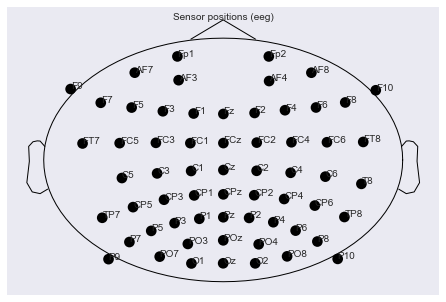

In [10]:
raw.plot_sensors(show_names=True);

### Apply a bandpass filter

Effective window size : 20.480 (s)


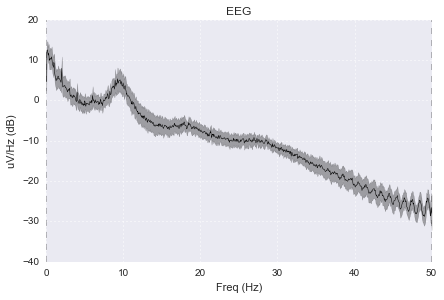

In [11]:
# Plot the power spectral density graph
raw.plot_psd(tmax=np.inf, average=True);

We can see that the data is already bandpass filtered, because there is no electric artifact at 50Hz or 60Hz. This is not strictly necessary, but we apply a bandpass filter (0.5-40Hz) anyway to conform to the original paper.

In [12]:
raw.filter(0.5, 40, method='iir') # Bandpass filter

Setting up band-pass filter from 0.5 - 40 Hz


<RawArray  |  None, n_channels x n_times : 64 x 84000 (840.0 sec), ~41.1 MB, data loaded>

### Build a MNE Epochs object

In [13]:
events = mne.find_events(raw)
event_id = {'distractor': 1, 'target': 2}
# Reject epochs were the signal exceeds 100uV in EEG channels or 200uV in the EOG channel
reject = {'eeg': 100e-6, 'eog': 200e-6}
# http://martinos.org/mne/stable/generated/mne.Epochs.html
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=(tmin, 0), reject=reject)
print(epochs)

840 events found
Events id: [1 2]
840 matching events found
0 projection items activated
<Epochs  |  n_events : 840 (good & bad), tmin : -0.1 (s), tmax : 0.9 (s), baseline : (-0.1, 0), ~135 kB, data not loaded,
 'distractor': 675, 'target': 165>


Here, we remove the "bad epochs", according to the reject dictionary set above:

In [14]:
epochs.load_data()
epochs.drop_bad()

Loading data for 840 events and 101 original time points ...
    Rejecting  epoch based on EOG : [u'EOG']
    Rejecting  epoch based on EOG : [u'EOG']
    Rejecting  epoch based on EEG : [u'Fp1']
    Rejecting  epoch based on EEG : [u'Fp1', u'Fp2', u'AF7', u'AF3', u'AF8']
    Rejecting  epoch based on EEG : [u'Fp1', u'Fp2', u'AF7', u'AF3', u'AF8']
    Rejecting  epoch based on EEG : [u'Fp1', u'Fp2', u'AF7', u'AF3', u'AF4', u'AF8', u'F5', u'F3']
    Rejecting  epoch based on EEG : [u'Fp1', u'Fp2', u'AF8']
    Rejecting  epoch based on EOG : [u'EOG']
    Rejecting  epoch based on EOG : [u'EOG']
    Rejecting  epoch based on EEG : [u'Fp1', u'Fp2', u'AF7', u'AF3', u'AF8', u'F5']
    Rejecting  epoch based on EEG : [u'Fp1']
    Rejecting  epoch based on EEG : [u'Fp1', u'Fp2', u'AF7', u'AF3', u'AF8']
    Rejecting  epoch based on EOG : [u'EOG']
14 bad epochs dropped


### Get evoked data

In [15]:
evoked_target = epochs['target'].average()
evoked_distractor = epochs['distractor'].average()

Show the signal mean for the **target** stimulus for each electrode and display the corresponding scalp topography:

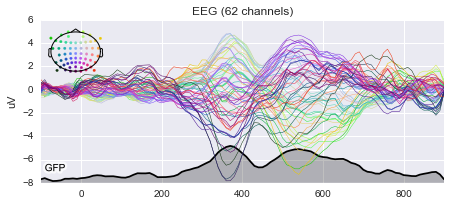

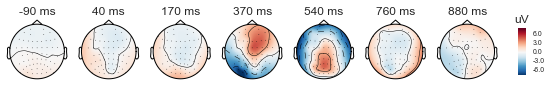

In [17]:
evoked_target.plot(spatial_colors=True, gfp=True);
evoked_target.plot_topomap(times='peaks');

Show the signal mean for the **distractor** stimulus for each electrode and display the corresponding scalp topography:

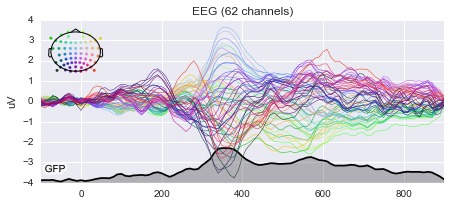

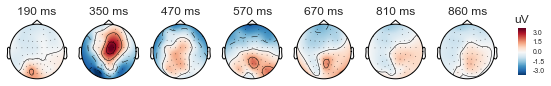

In [18]:
evoked_distractor.plot(spatial_colors=True, gfp=True);
evoked_distractor.plot_topomap(times='peaks');

### Plot raw trials

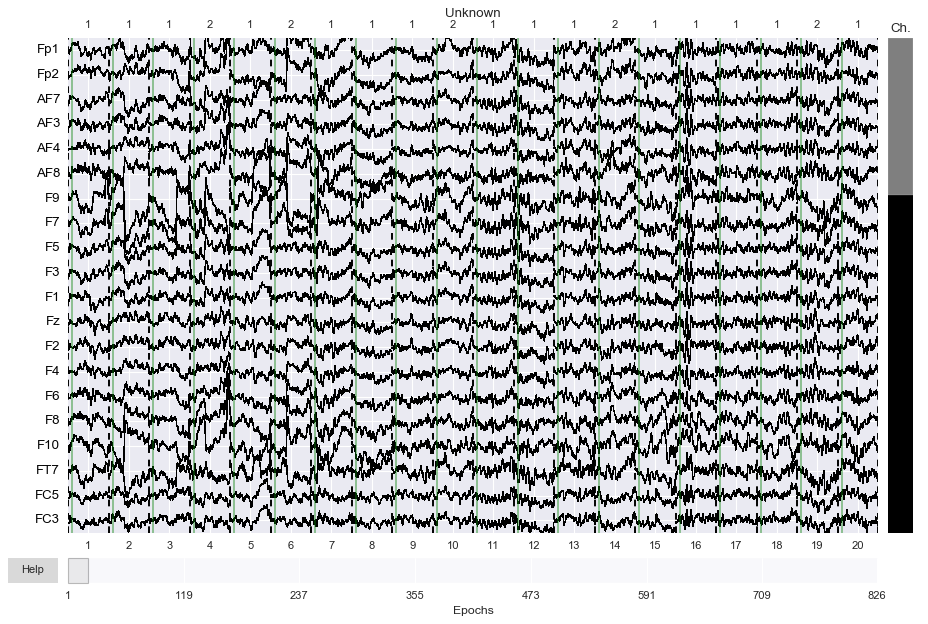

In [19]:
epochs.plot();

### Compare evoked data on a selection of electrodes

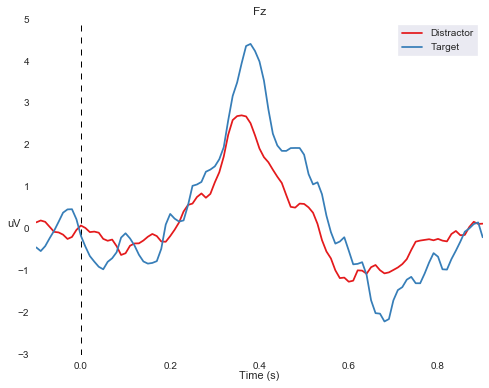

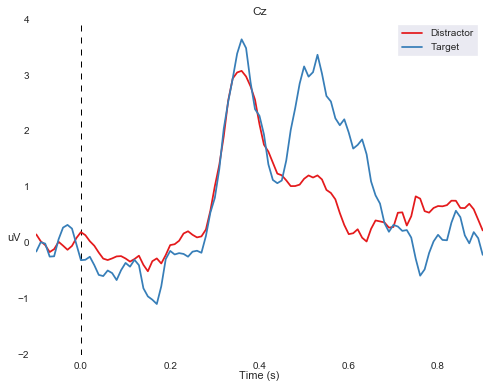

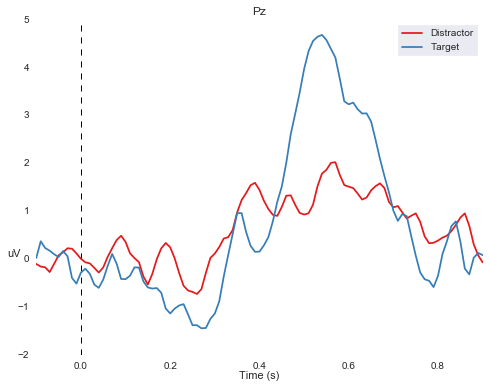

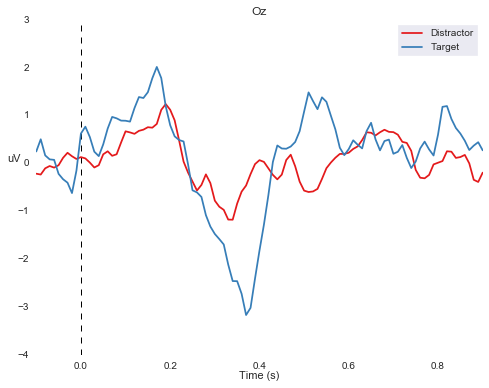

In [20]:
picks = [evoked_target.ch_names.index(channel) for channel in ['Fz', 'Cz', 'Pz', 'Oz']]
for pick in picks:
    mne.viz.plot_compare_evokeds({'Target': evoked_target, 'Distractor': evoked_distractor}, picks=pick)

We can see a clear P300 at Oz.

### Release memory

In [21]:
del df
del X
del raw
del epochs
del evoked_target
del evoked_distractor
del events
del picks

## Checkpoint

Run the **Dependencies** block and jump here directly.

## Benchmark

### Configuration

In [22]:
input_dir = '../data/input/'
output_dir = '../data/output/'
eeg_file = 'EEG.h5'
prefix = time.strftime('%Y%m%d-%H%M', time.gmtime()) + '_' # This will be prepended to saved files
implementation = 0 # RNN implementation: 0 for CPU, 1 for RAM, 2 for GPU

### Initialization

All the relevant code can be found in `erp.py`.

In [23]:
run = erp.ERP(input_dir, output_dir) # Class initialization
run.load(eeg_file) # Load EEG data

### Build models

**Warning!** The execution of this cell can take several hours. Uncomment and run at your own risk. For your  convenience, pre-computed results are available in the output directory.

In [24]:
start = time.time()

#run.across_lda(prefix=prefix)

elapsed = (time.time() - start) / 60
print("\nElapsed: %f minutes" % elapsed)


Elapsed: 0.000001 minutes


### Results

In [25]:
def plot_auc_mean(data):
    conditions = ['C', 'A', 'M']
    matrix = []
    for c_train in conditions:
        for c_test in conditions:
            matrix.append([c_train, c_test, round(data.loc[c_train, c_test].mean(), 2)])
    matrix = pd.DataFrame(matrix, columns=['Train', 'Test', 'Mean'])
    matrix = matrix.pivot('Train', 'Test', 'Mean').reindex(conditions, conditions)
    sns.heatmap(matrix, annot=True)

def plot_auc_participant(data):
    data = pd.DataFrame(data)
    data.reset_index(inplace=True)
    data.columns = ['Train', 'Test', 'Participant', 'AUC']
    sns.swarmplot(x='Train', y='AUC', hue='Test', data=data);

Uncomment if you want to use your own results:

In [26]:
results = pd.read_hdf(output_dir + 'final_across_lda.h5', 'df')
#results = pd.read_hdf(output_dir + prefix + 'across_lda.h5', 'df')

Display the mean AUC for each condition pair:

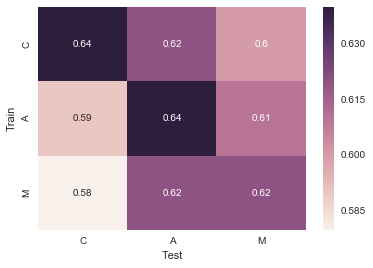

In [27]:
plot_auc_mean(results)

Plot the AUC score for each subject and condition pair:

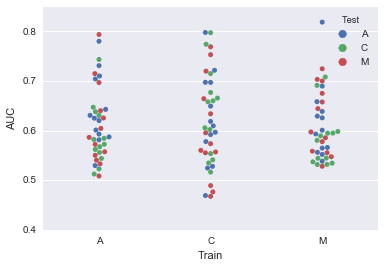

In [28]:
plot_auc_participant(results)

### Release memory

In [29]:
del run

## Checkpoint

Run the **Dependencies** block and jump here directly.

## Final model

### Configuration

In [30]:
input_dir = '../data/input/'
output_dir = '../data/output/'
eeg_file = 'EEG.h5'
prefix = time.strftime('%Y%m%d-%H%M', time.gmtime()) + '_' # This will be prepended to saved files
implementation = 0 # RNN implementation: 0 for CPU, 1 for RAM, 2 for GPU

### Initialization

All the relevant code can be found in `erp.py`.

In [31]:
run = erp.ERP(input_dir, output_dir) # Class initialization
run.load(eeg_file) # Load EEG data

### Build models

**Warning!** The execution of this cell below can take from several days (high-end GPU) to several weeks (CPU). Uncomment and run at your own risk. For your  convenience, pre-computed results are available in the output directory.

In [32]:
start = time.time()

#run.across_lstm(prefix=prefix, implementation=implementation)

elapsed = (time.time() - start) / 60
print("\nElapsed: %f minutes" % elapsed)


Elapsed: 0.000001 minutes


### Results

In [33]:
def plot_auc_mean(data):
    conditions = ['C', 'A', 'M']
    matrix = []
    for c_train in conditions:
        for c_test in conditions:
            matrix.append([c_train, c_test, round(data.loc[c_train, c_test].mean(), 2)])
    matrix = pd.DataFrame(matrix, columns=['Train', 'Test', 'Mean'])
    matrix = matrix.pivot('Train', 'Test', 'Mean').reindex(conditions, conditions)
    sns.heatmap(matrix, annot=True)

def plot_auc_participant(data):
    data = pd.DataFrame(data)
    data.reset_index(inplace=True)
    data.columns = ['Train', 'Test', 'Participant', 'AUC']
    sns.swarmplot(x='Train', y='AUC', hue='Test', data=data);
    
def series(data, model='best_auc'):
    
    """Parse the JSON object so the data can be used for plot_auc_mean() and plot_auc_participant()."""
    
    keys = []
    values = []
    for result in results:
        index = (result['c_train'], result['c_test'], result['p'])
        keys.append(index)
        values.append(result['auc'][model])
    keys = pd.MultiIndex.from_tuples(keys, names=['c_train', 'c_test', 'p'])
    data = pd.Series(values, index=keys)
    return data.sort_index()    

Uncomment if you want to use your own results:

In [34]:
results = json.loads(open(output_dir + 'final_across_lstm.json').read())
#results = json.loads(open(output_dir + prefix + 'across_lstm.json').read())

Display the mean AUC for each condition pair:

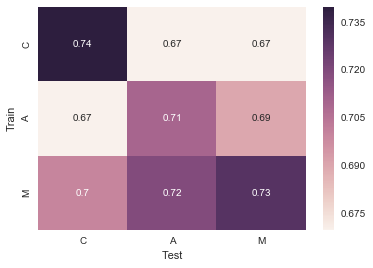

In [35]:
plot_auc_mean(series(results, 'best_auc'))

Plot the AUC score for each subject and condition pair:

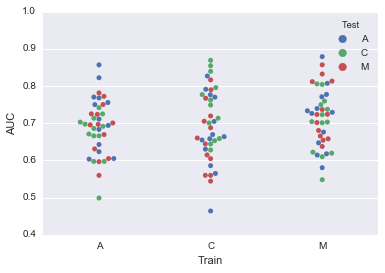

In [36]:
plot_auc_participant(series(results, 'best_auc'))

Get the average epoch selected by the early stopping rule:

In [37]:
r = results[:] # Make a copy
epoch_best_auc = [result['history']['val_auc'].index(max(result['history']['val_auc'])) for result in r]
print("Average selected model epoch: %f (std: %f)" % (np.mean(epoch_best_auc), np.std(epoch_best_auc)))

Average selected model epoch: 46.051282 (std: 17.836315)


Plot the losses:

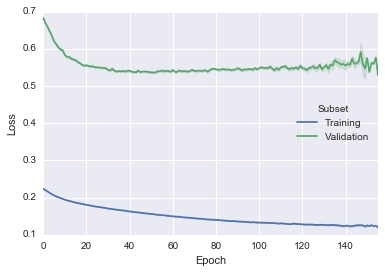

In [39]:
r = results[:] # Make a copy

# Get train and validation losses from history
epochs = [len(result['history']['loss']) for result in r]
epoch_max = max(epochs)    
epoch_len = len(epochs)
train_loss = np.empty((epoch_len, epoch_max))
val_loss = np.empty((epoch_len, epoch_max))
for i, result in enumerate(r):
    result['history']['loss'].extend([np.nan] * (epoch_max - len(result['history']['loss']))) # NaN padding
    result['history']['val_loss'].extend([np.nan] * (epoch_max - len(result['history']['val_loss']))) # NaN padding
    train_loss[i] = result['history']['loss']
    val_loss[i] = result['history']['val_loss']

# Format them so they can be used by sns.tsplot()
losses = []
for id, id_losses in enumerate(zip(train_loss, val_loss)):
    for epoch, epoch_losses in enumerate(zip(id_losses[0], id_losses[1])):
        losses.append([id, epoch, 'Training', epoch_losses[0]])
        losses.append([id, epoch, 'Validation', epoch_losses[1]])        
losses = pd.DataFrame(losses, columns=('ID', 'Epoch', 'Subset', 'Loss'))

# Plot
sns.tsplot(time='Epoch', value="Loss", unit='ID', condition='Subset', data=losses, estimator=np.nanmean)

### Release memory

In [40]:
del run

## Checkpoint

Run the **Dependencies** block and jump here directly.

## Spatio-temporal visualization

### Configuration

In [41]:
input_dir = '../data/input/'
output_dir = '../data/output/'
eeg_file = 'EEG.h5'
prefix = time.strftime('%Y%m%d-%H%M', time.gmtime()) + '_' # This will be prepended to saved files
implementation = 0 # RNN implementation: 0 for CPU, 1 for RAM, 2 for GPU

### Initialization

All the relevant code can be found in `erp.py`.

In [42]:
run = erp.ERP(input_dir, output_dir) # Class initialization
run.load(eeg_file) # Load EEG data

### Get evoked data

In [43]:
X, y, epochs = run.get_Xy(verbose=False) # Get the full dataset, this can take a few minutes

In [44]:
# We are only interested by the epochs object
del X
del y

In [45]:
evoked_target = epochs['target'].average()
evoked_distractor = epochs['distractor'].average()

### Scalp topgraphies

Target:

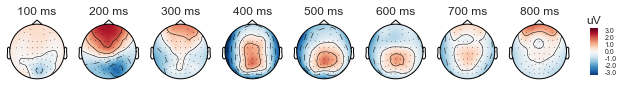

In [46]:
evoked_target.plot_topomap(times=[.1, .2, .3, .4, .5, .6, .7, .8]);

Distractor:

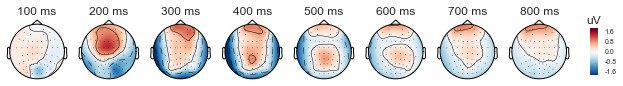

In [47]:
evoked_distractor.plot_topomap(times=[.1, .2, .3, .4, .5, .6, .7, .8]);